In [2]:
%pylab inline
import math
import polyline
import itertools
import pandas as pd
import pylab as plt
from glob import glob
import seaborn as sns
from itertools import cycle
from scipy.optimize import curve_fit
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans,AgglomerativeClustering
# --------------------------------------------------------
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('colorblind')

def get_df(test):
    rawdf = pd.read_pickle('../data/{0:s}_latest.pdpkl'.format(test))
    return rawdf

prj = 1
tests = ['inside','outin','bigpar']
N_CLUSTERS = [8,10,10][prj] # 10 for test 0
BOUNDARIES = [(250000,270000,6210000,6227000),
              (245000,275000,6205000,6235000),
              (245000,275500,6200000,6235000)][prj]
df = get_df(tests[prj])
TITLE = tests[prj]

!mkdir plots/

Populating the interactive namespace from numpy and matplotlib


/home/astyonax/.anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['poly']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


mkdir: cannot create directory ‘plots/’: File exists


In [3]:
data = df[(df.kind!='step') | (df['mode']=='walking')][:]

df.groupby(('mode','kind')).count()

departure  distance  duration  haversine_distance      p1  \
mode      kind                                                              
bicycling full      22967     22967     22967               22967   22967   
          step     172780    172780    172780              172780  172780   
driving   full      22967     22967     22967               22967   22967   
          step     147916    147916    147916              147916  147916   
transit   full      22967     22967     22967               22967   22967   
          step      28033     28033     28033               28033   28033   
walking   step      49419     49419     49419               49419   49419   

                    p2  polyline  walk_distance  duration[m]  distance[km]  \
mode      kind                                                               
bicycling full   22967     22967              0        22967         22967   
          step  172780         0              0       172780        172780   
driving   full   22967     22967              0        22967         22967   
          step  147916         0              0       147916        147916   
transit   full   22967     22967              0        22967         22967   
          step   28033         0              0        28033         28033   
walking   step   49419         0              0        49419         49419   

                coupled  bicycling_faster_driving    same  
mode      kind                                             
bicycling full    22967                     22967   22967  
          step   172780                    172780  172780  
driving   full    22967                     22967   22967  
          step   147916                    147916  147916  
transit   full    22967                     22967   22967  
          step    28033                     28033   28033  
walking   step    49419                     49419   49419

In [4]:
print 'distance',df.distance.iloc[0]
print 'distance[km]',df['distance[km]'].iloc[0]
print 'haversine_distance',df.haversine_distance.iloc[0]

distance 12698.0
distance[km] 8.7207835156
haversine_distance 8720.7835156


In [5]:
from scipy.optimize import curve_fit
def poly(x,*coeffs):
    out = 0
    for i,c in enumerate(coeffs):
        out += x**i*c
    return out

def fitit(x,y,func,p0):
    popt,pcov = curve_fit(func,p0=p0,xdata=x,ydata=y)
    ix = np.sort(x)
    return ix,poly(ix,*popt)

#sliding average and variance
def wvar(x,y,xm,xM):
    return y[(x>xm) & (x<xM)].var()
def mvar(x,y,xm,xM):
    return y[(x>xm) & (x<xM)].mean()

# sliding average every dx, and window win
def wvarlist(x,y,dx,win):
    vy = []
    my = []
    vx = []
    for x0 in np.arange(x.min(),x.max(),dx):
        xm=x0-win
        xM=x0+win
        my.append(mvar(x,y,xm,xM))
        vy.append(wvar(x,y,xm,xM))
        vx.append(x0)
    return np.asarray(vx),np.asarray(my),np.asarray(vy)
        
data['haver_digit']=np.digitize(data.haversine_distance,np.arange(0,10000,1000))
order = """bicycling
driving
transit
walking""".split()
# print order

# sns.boxplot(x='haver_digit',y='duration[m]',data=data,hue='mode',hue_order=order,width=.5,linewidth=1.25)
c=0

# get walking speed:
_y = data[data['mode']=='walking']
x,y = _y['distance[km]'],_y['duration[m]']
popt,pcov = curve_fit(poly,p0=[0,]*3,xdata=x,ydata=y)
min_per_km = popt[1]
h_per_km = min_per_km/60.
print 'walking speed', 1/h_per_km

walking speed 3.52018203357


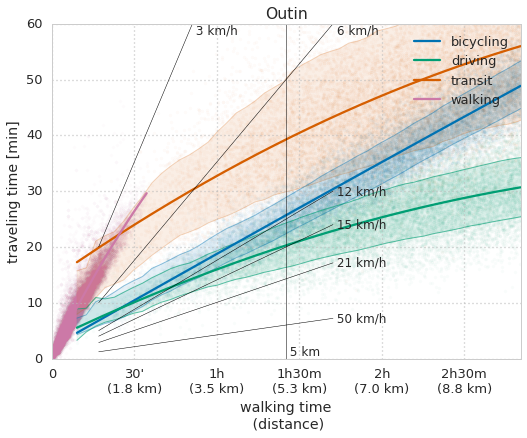

In [3]:
zo={'driving':3,'bicycling':2,'transit':1}
import itertools
scale = 1.2
fig,ax=plt.subplots(1,1,figsize=(7*scale,5*scale))
ax.cla()
for _x,_y in data.groupby('mode'):
    ix = _y['distance[km]']
    x,y = _y['distance[km]']*h_per_km,_y['duration[m]']
    ax.scatter(x,y.values,\
               color=sns.color_palette()[c],s=12,linewidth=0,zorder=-10,alpha=.025)
    
    fx,fy = fitit(x,y,func=poly,p0=[0,]*3)
    
    ax.plot(fx,fy,color=sns.color_palette()[c],label=_x)
    if not _x=='walking':
        vx,my,vy = wvarlist(ix,y,0.2,0.500)
        vy=vy**.5
        ax.fill_between(vx*h_per_km,my-vy,my+vy,color=sns.color_palette()[c],alpha=.1,zorder=-10+zo[_x])
        ax.plot(vx*h_per_km,my+vy,color=sns.color_palette()[c],lw=1,zorder=-10+zo[_x],alpha=.2*zo[_x])
        ax.plot(vx*h_per_km,my-vy,color=sns.color_palette()[c],lw=1,zorder=-10+zo[_x],alpha=.2*zo[_x])
        c+=1
    
    if _x =='walking':
        ha = itertools.cycle(['left','left'])
        for km_per_h in [3,6,12,15,21,50]:
            x=np.arange(1,10,5.)
            y=x/km_per_h # unit of h
            y *= 60 # unit of min
            ax.plot(x*h_per_km,y,'-',c='k',lw=.5,zorder=2)
            x0=x[-1]*h_per_km
            y0=y[-1]
            va = 'center'
            if y0>=60:
                y0 = 60
                x0 = 60*km_per_h/60.*h_per_km
                va = 'top'
            ax.text(x0,y0,' {0:d} km/h'.format(km_per_h),verticalalignment=va,horizontalalignment=ha.next(),fontsize=12)
        
ax.set_ylim(0,60)
ax.set_xlim(0,10*h_per_km)
ax.set_ylabel('traveling time [min]')
ax.set_xlabel('walking time\n (distance)')

xticks=[0,.5,1,1.5,2,2.5]
xticks_labels=['0','30\'','1h','1h30m','2h','2h30m']
xticks_labels=['{0:s}\n({1:.1f} km)'.format(j,i/h_per_km) for i,j in zip(xticks,xticks_labels)]
xticks_labels[0]='0'
ax.xaxis.set_ticks(xticks)
ax.xaxis.set_ticklabels(xticks_labels)

ax.axvline(5*h_per_km,color='k',lw=.5)
# ax.axvline(5*1.5*h_per_km,color='k',lw=.5)
ax.text(5*h_per_km,0,' 5 km',verticalalignment='bottom',horizontalalignment='left',fontsize=12)
# ax.text(5*1.5*h_per_km,0,' 7.5 km',verticalalignment='bottom',horizontalalignment='left',fontsize=12)
ax.grid(True,color='#bbbbbb',which='major',linestyle=':')
ax.legend()
ax.set_title(TITLE.capitalize())
fig.savefig('../plots/{0:s}_timing.png'.format(TITLE),dpi=96,bbox_inches='tight')